<a href="https://colab.research.google.com/github/MoghazyCoder/Plant-Spieces/blob/master/Plant_Wilt_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !rm -rf /tmp/test

In [0]:
# from __future__ import absolute_import, division, print_function, unicode_literals

# !pip install tf-nightly-gpu-2.0-preview
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
tf.__version__

'1.14.0'

In [0]:
import os
import zipfile
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [60]:
TRAINING_DIR = "/content/drive/My Drive/wilt/dataset"



train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=25,
      width_shift_range=0.1,
      height_shift_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split = 0.2)



train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=60,
                                                    class_mode='categorical',
                                                    target_size=(224, 224),
                                                    subset='training')


validation_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                              batch_size=60,
                                                              class_mode='categorical',
                                                              target_size=(224, 224),
                                                              subset='validation')


Found 119 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


In [61]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((60, 224, 224, 3), (60, 2))

In [62]:
print (train_generator.class_indices)

{'grass': 0, 'wilt_grass': 1}


In [0]:
IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.densenet.DenseNet121(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights="imagenet")

# keras.applications.densenet.DenseNet201(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

### Add a classification head

In [0]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(2, activation='softmax')
])

In [0]:
from tensorflow import keras


callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-3,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=5,
        verbose=1)
]

In [0]:
base_model.trainable = True

In [67]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 300

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  427


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [69]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          294944    
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 7,332,514
Trainable params: 3,184,418
Non-trainable params: 4,148,096
_________________________________________________________________


In [70]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 112


In [71]:
history = model.fit(train_generator, 
                         epochs=200,
                         callbacks = callbacks,
                         validation_data=validation_generator)

Epoch 1/200
2/2 [==============================] - 20s 10s/step - loss: 0.9564 - acc: 0.5462 - val_loss: 0.5938 - val_acc: 0.6786
Epoch 2/200
2/2 [==============================] - 1s 591ms/step - loss: 0.8099 - acc: 0.6050 - val_loss: 0.5886 - val_acc: 0.6786
Epoch 3/200
2/2 [==============================] - 2s 966ms/step - loss: 0.7155 - acc: 0.5462 - val_loss: 0.6558 - val_acc: 0.6429
Epoch 4/200
2/2 [==============================] - 2s 960ms/step - loss: 0.6865 - acc: 0.6050 - val_loss: 0.6063 - val_acc: 0.7143
Epoch 5/200
2/2 [==============================] - 2s 927ms/step - loss: 0.7181 - acc: 0.5546 - val_loss: 0.7101 - val_acc: 0.5000
Epoch 6/200
2/2 [==============================] - 2s 944ms/step - loss: 0.5910 - acc: 0.6555 - val_loss: 0.6450 - val_acc: 0.6786
Epoch 7/200
2/2 [==============================] - 2s 865ms/step - loss: 0.5504 - acc: 0.6975 - val_loss: 0.5974 - val_acc: 0.7143
Epoch 00007: early stopping


In [0]:
model.save('my_model.h5')

model2 = keras.models.load_model('my_model.h5')

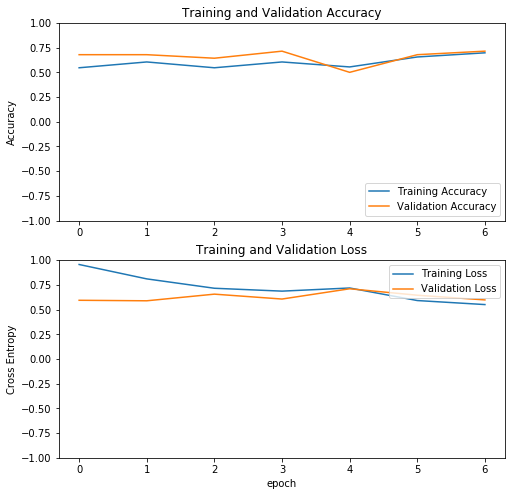

In [72]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([-1,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([-1,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
classes = {0 : 'healthy' , 1 :  'wilt-grass'}
# {'Chlorophytum comosum': 0, 'Ficus Benjamina': 1, 'grass': 2, 'philodendron': 3, 'wheat': 4}

Text(0.5, 1.0, 'Predicted:healthy\n Actual type : healthy')

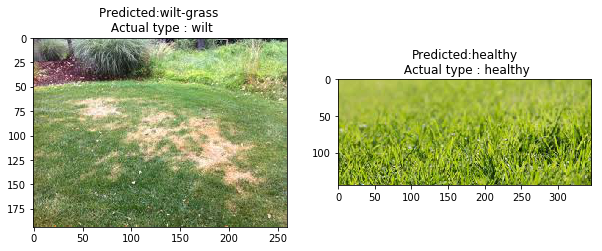

In [74]:
from keras.preprocessing import image
import numpy as np
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg




f = plt.figure(figsize=(10,10))

# print (f)
img_path = '/content/drive/My Drive/wilt/test/wilt_grass/download (1).jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
img=mpimg.imread(img_path)
f.add_subplot(221)

plt.imshow(img)


x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
plt.title('Predicted:' + str( classes[np.argmax(preds)]      )    + " \n Actual type : wilt" )


img_path = '/content/drive/My Drive/wilt/test/grass/images (10).jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
img=mpimg.imread(img_path)
f.add_subplot(222)

plt.imshow(img)

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
plt.title('Predicted:' + str( classes[np.argmax(preds)]      )    + "\n Actual type : healthy" )



In [75]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    "/content/drive/My Drive/wilt/test",
    batch_size=1,
    class_mode='categorical',
    target_size=(224, 224))

Found 21 images belonging to 2 classes.


In [0]:
predict = model.evaluate_generator(test_generator,steps = 20)

In [77]:
predict

[0.5029757746960968, 0.8]

In [78]:
model.metrics_names

['loss', 'acc']